## EC Lab 2
### Summary
The aim of lab is to learn a reinforcement learning agent to play simple GYM environment (LunarLander-v2). The agent is a neural network that takes as input current state of a game and outputs probabilities for actions. (https://gym.openai.com/).

You have a pattern script with main structure of algorithm, but you have to repair it or change it completely, as you wish. You can change current mutation, crossover, selection, evolution scheme or even use another algorithm as PSO.  To use LunarLander, you need to uncomment config for it, because by default it is stand for CartPole environment.

As for LunarLander, the agent receives following rewards: -0.1 for each time you launch the engine, -100 for broke and +200 for successful landing. Therefore, good results starts from +100 approximately.

Please, work with this script and try to learn the agent how to play and achieve good scores. Lets say about restriction:
max_pop_size = 20;
maximum_iterations = 200.

Prepare IPython Notebook with all your things there (maybe some good analysis, and ideas). Send me only IPython file topic ec_lab2_surname on mihail.melnik.ifmo@gmail.com.

In [1]:
# Imports
from deap import tools, base, creator
import numpy as np
from function_opt.ga_scheme import eaMuPlusLambda
import numpy.random as rnd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import gym
from function_opt.draw_log import draw_log
from copy import deepcopy

creator.create("BaseFitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.BaseFitness)

2021-10-25 11:30:20.876174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-25 11:30:20.876211: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
class RL_ga_experiment:
    def factory(self):
        individual = list()
        for i in range(len(self.params)):
            if i % 2 == 0:
                individual.append(rnd.normal(0.1, 0.2, size=self.params[i].shape))
            else:
                individual.append(np.zeros(shape=self.params[i].shape))
        return creator.Individual(individual)


    def mutation(self, individual):
        for i in range(len(individual)):
            if i % 2 == 0:
                for j in range(len(individual[i])):
                    for k in range(len(individual[i][j])):
                        if rnd.random() < 0.15:
                            individual[i][j] += rnd.normal(0.0, 0.2)
        return individual,


    def crossover(self, p1, p2):

        c1 = list()
        c2 = list()

        c1.append(deepcopy(p1[0]))
        c1.append(deepcopy(p1[1])) # zero
        c1.append(deepcopy(p2[2]))
        c1.append(deepcopy(p1[3])) # zero
        c1.append(deepcopy(p1[4]))
        c1.append(deepcopy(p1[5])) # zero

        c2.append(deepcopy(p2[0]))
        c2.append(deepcopy(p2[1]))  # zero
        c2.append(deepcopy(p1[2]))
        c2.append(deepcopy(p2[3]))  # zero
        c2.append(deepcopy(p2[4]))
        c2.append(deepcopy(p2[5]))  # zero

        return creator.Individual(c1), creator.Individual(c2)


    def __init__(self, input_dim, l1, l2, output_dim, pop_size, iterations):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = l1
        self.l2 = l2
        self.pop_size = pop_size
        self.iterations = iterations

        self.model = self.build_model()
        self.params = self.model.get_weights()

        #self.env = gym.make("CartPole-v0")
        # todo uncomment for LunarLander
        self.env = gym.make("LunarLander-v2")

        self.engine = base.Toolbox()
        self.engine.register('map', map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register('population', tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register('mutate', self.mutation)
        self.engine.register("mate", self.crossover)
        self.engine.register('select', tools.selTournament, tournsize=3)
        self.engine.register('evaluate', self.fitness)
        self.render = False


    def compare(self, ind1, ind2):
        result = True
        for i in range(len(ind1)):
            if i % 2 == 0:
                for j in range(len(ind1[i])):
                    for k in range(len(ind1[i][j])):
                        if ind1[i][j][k] != ind2[i][j][k]:
                            return False
        return result


    def run(self):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, similar=self.compare)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register('min', np.min)
        stats.register('max', np.max)
        stats.register('avg', np.mean)
        stats.register('std', np.std)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(0.5 * self.pop_size), cxpb=0.9, mutpb=0.9,
                                  ngen=self.iterations, verbose=True, halloffame=hof, stats=stats)
        best = hof[0]
        print("Best fitness = {}".format(best.fitness.values[0]))
        return log, best


    def build_model(self):
        model = Sequential()
        model.add(InputLayer(self.input_dim))
        model.add(Dense(self.l1, activation='relu'))
        model.add(Dense(self.l2, activation='relu'))
        model.add(Dense(self.output_dim, activation='softmax'))
        model.compile(optimizer='adam', loss='mse')
        return model
        

    def fitness(self, individual):
        self.model.set_weights(individual)
        scores = []
        for _ in range(1):
            state = self.env.reset()
            score = 0.0
            for t in range(200):
                if self.render:
                    self.env.render()
                act_prob = self.model.predict(state.reshape(1, self.input_dim)).squeeze()
                action = rnd.choice(np.arange(self.output_dim), 1, p=act_prob)[0]
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                state = next_state
                if done:
                    break
            scores.append(score)
        return np.mean(scores),


2021-10-25 11:30:23.033940: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/shyju/Downloads/EC_ITMO/env/lib/python3.8/site-packages/cv2/../../lib64:
2021-10-25 11:30:23.033998: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-25 11:30:23.034037: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (shyju-R830): /proc/driver/nvidia/version does not exist
2021-10-25 11:30:23.279330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


gen	nevals	min    	max     	avg     	std    
0  	20    	-1495.3	-34.8881	-481.312	359.808
1  	10    	-743.884	-34.8881	-242.348	196.221
2  	10    	-510.386	-34.8881	-105.716	99.4132
3  	10    	-161.919	-34.8881	-66.7775	36.9335
4  	10    	-112.634	-33.84  	-45.7963	23.5197
5  	10    	-136.082	-33.84  	-49.0485	30.3038
6  	10    	-104.057	9.99955 	-34.7042	21.2631
7  	10    	-109.559	9.99955 	-25.4479	28.2857
8  	10    	-34.8881	9.99955 	-11.8955	21.9009
9  	10    	-109.684	9.99955 	-4.72695	29.6912
10 	10    	-82.2171	9.99955 	0.978351	23.2032
11 	10    	-33.3201	9.99955 	7.14328 	9.75711
12 	10    	-137.795	9.99955 	-4.14231	42.4734
13 	10    	-110.066	270.143 	43.0178 	98.9029
14 	10    	-115.72 	270.143 	55.7423 	110.602
15 	10    	-212.727	270.143 	102.921 	144.623
16 	10    	-3.80609	270.143 	178.403 	125.054
17 	10    	-139.543	270.143 	190.286 	143.004
18 	10    	9.99955 	270.143 	244.129 	78.0431
19 	10    	-123.872	270.143 	236.745 	101.977
20 	10    	-151.467	270.143 	209.749

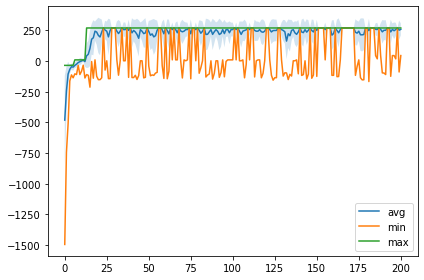

In [3]:
if __name__ == '__main__':
    # config for CartPole
    # input_dim = 4
    # l1 = 20
    # l2 = 12
    # output_dim = 2

    # todo config for Lunar Lander
    input_dim = 8
    l1 = 128
    l2 = 90
    output_dim = 4

    pop_size = 20
    iterations = 200

    exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
    exp.render = False
    log, best = exp.run()

    draw_log(log)
    exp.render = True
    for _ in range(10):
        exp.fitness(best)